In [1]:
import os
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [24]:
DATA_DIR = Path('csse_covid_19_data/csse_covid_19_time_series/')

filename = DATA_DIR / 'time_series_covid19_confirmed_global.csv'

title = 'Cases'

countries = [
    'France', 
    'United Kingdom'
]

log = False
move = 5
start = 45
days_forward = 10

## Get COVID data

In [25]:
def get_region(line, start=0):
    region = ''
    break_ = True
    for i in range(start, len(line)):
        region += ',' + line[i]
        if line[i].startswith('"'):
            break_ = False
        if line[i].endswith('"'):
            break_ = True
        if break_:
            break
    return region.strip(','), i

In [26]:
confirmed = {}
coordinates = np.empty((258, 2))
id2country = []
with open(filename) as f:
    f.readline()  # skip header
    for n, line in enumerate(f):
        line = line.rstrip('\n').split(',')
        
        key, i = get_region(line) 
        key2, i = get_region(line, i+1)
        if key != '':
            key += ','
        key += key2
        
        coordinates[n][0] = float(line[i+1])
        coordinates[n][1] = float(line[i+2])
        
        i += 3
        confirmed[key] = np.array([
            float(j) for j in line[i:] if j != '']
        )
        
        id2country.append(key)
        
country2id = {country: i for i, country in enumerate(id2country)}

## Create population file

In [27]:
a_countries = []

a_coordinates = np.empty((283, 2))

with open('world_coordinates.csv') as f:
    f.readline()
    for i, line in enumerate(f):
        line = line.rstrip('\n').split(',')
        a_countries.append(line[1])
        a_coordinates[i][0] = float(line[2])
        a_coordinates[i][1] = float(line[3])

In [28]:
from scipy.spatial.distance import cdist

dists = cdist(coordinates, a_coordinates)
ids = np.argmin(dists, axis=1)

# for i in range(len(id2country)):
#     if a_countries[ids[i]] != id2country[i]:
#         print(id2country[i], '---->', a_countries[ids[i]])

In [29]:
population = {}
with open('population_by_country_2020.csv') as f:
    f.readline()
    for line in f:
        line = line.rstrip('\n').split(',')
        population[line[0]] = int(line[1])

with open('population.csv', 'w') as f:
    for i, country in enumerate(id2country):
        current_pop = population[a_countries[ids[i]]]
        f.write('%s;%d\n' % (country, current_pop))

## Read population file

In [30]:
population = {}

with open('population.csv') as f:
    for line in f:
        line = line.rstrip('\n').split(';')
        population[line[0]] = int(line[1])

## Plot evolution

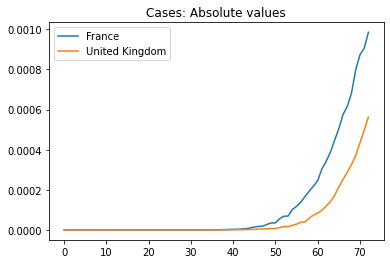

In [31]:
def plot(ax, country, log=True):
    x = np.arange(confirmed[country].shape[0])

    if log:
        ax.set_yscale('log')

    ax.plot(x, confirmed[country] / population[country], label=country)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title(title + ': Absolute values')

for c in countries:
    plot(ax, c, log)
ax.legend()

## Exponential analysis

In [32]:
def get_ratios(country, start=0):
    ratios = []
    for i in range(start, len(confirmed[country])):
        if confirmed[country][i-1] == 0:
            ratio = 1
        else:
            ratio = confirmed[country][i] / confirmed[country][i-1]
        ratios.append(ratio)
    return np.array(ratios)

ratios = []
for c in countries:
    ratios.append(get_ratios(c, start))
# avg = ratios.mean()
# std = ratios.std()
# avg, std

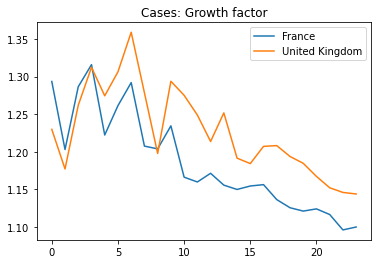

In [33]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n = len(confirmed['France'][start:]) - (move - 1)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title(title + ': Growth factor')

for c, r in zip(countries, ratios):
    ax.plot(range(n), moving_average(r, move), label=c)
ax.legend()

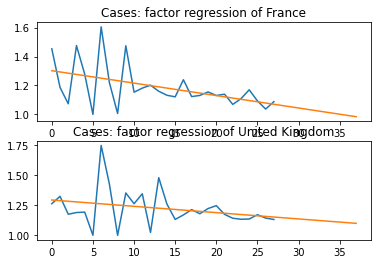

In [34]:
X = np.arange(len(ratios[0])).reshape(-1, 1)

fig = plt.figure()

n = len(confirmed['France'][start:])
for i, (c, r) in enumerate(zip(countries, ratios)):
    ax = fig.add_subplot(len(countries), 1, i+1)
    Y = r.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, Y)
    model.coef_,model.intercept_
    ax.set_title(title + ': factor regression of ' + c)
    ax.plot(range(n), r)
    ax.plot(range(n + days_forward), 
            model.coef_[0, 0] * np.arange(n + days_forward) + model.intercept_[0])